In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from ngboost import NGBRegressor
from ngboost.distns import Normal, Poisson
from ngboost.scores import CRPScore, MLE
from ngboost.ngboost import NGBoost
from sklearn.tree import DecisionTreeRegressor

from hyperopt import hp, tpe, space_eval
from hyperopt.pyll.base import scope
from hyperopt.fmin import fmin
from hyperopt import STATUS_OK, Trials

import logging

In [2]:
# options
pd.set_option('max_columns',100)
plt.style.use('fivethirtyeight')
warnings.simplefilter('ignore')
seed = 1

In [3]:
# Data dirctory
data_dir = Path('../data/')
data_file = data_dir / 'data.csv'

In [4]:
# Data
# 0:AAR / 1:EAD / 2:ADR / 3:EDD는 고정  , 나머지는 순서 상관 없음
Data = pd.read_csv(data_file, index_col=0)

***
***
***

# Data Selection

In [5]:
# 필요없는 것을 버리기
Data_temp = Data.drop('TMP', axis=1)
Data_temp = Data_temp.drop('TD', axis=1)
Data_temp = Data_temp.drop('HM', axis=1)
Data_temp = Data_temp.drop('PS', axis=1)
Data_temp = Data_temp.drop('PA', axis=1)

#고층바람 너무 높은 고도는 뺴자 
Data_temp = Data_temp.drop('WD_400', axis=1)
Data_temp = Data_temp.drop('WD_500', axis=1)
Data_temp = Data_temp.drop('WD_700', axis=1)
Data_temp = Data_temp.drop('WS_400', axis=1)
Data_temp = Data_temp.drop('WS_500', axis=1)
Data_temp = Data_temp.drop('WS_700', axis=1)

# drop TAF
for i in range(6,30,6):
    Data_temp = Data_temp.drop(f'WDIR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'WSPD_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'WG_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'VIS_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'WC_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'CLA_1LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'BASE_1LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'CLA_2LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'BASE_2LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'CLA_3LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'BASE_3LYR_t{i}', axis=1)

In [6]:
# 각 시간에 맞는 TAF로 나누기
taf6 = [12,18,24]
taf12 = [6,18,24]
taf18 = [6,12,24]
taf24 = [6,12,18]
    
# 각 시간에 맞는 taf 넣기
data_taf = {}
for i in range(6,30,6):
    data_taf[f'Data_{i}'] = Data_temp    
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WDIR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WSPD_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WG_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'VIS_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WC_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'CLA_1LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'BASE_1LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'CLA_2LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'BASE_2LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'CLA_3LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'BASE_3LYR_t{i}'])
    
Data_6 = data_taf['Data_6']
Data_12 = data_taf['Data_12']
Data_18 = data_taf['Data_18']
Data_24 = data_taf['Data_24']

In [9]:
# 예측할 시간에 맞는 Data로 넣기
# 0-6 : Data_6 / 6-12 : Data_12 / 12-18 : Data_18 / 18-24 : Data_24
Data_raw = Data_6
Data_m = Data_6
Data_m = Data_m.drop('AAR', axis=1)
Data_m = Data_m.drop('ADR', axis=1)


# Arrival
y_a = Data_raw.AAR.to_numpy()
X_a = Data_m.to_numpy()
#X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size = 0.1, random_state = seed)
X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.11, random_state = 13) 


# Departure
y_d = Data_raw.ADR.to_numpy()
X_d = Data_m.to_numpy()
#X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size = 0.1, random_state = seed)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train_d, y_train_d, test_size=0.11, random_state = 13) 

# val은 hyperparameter 검증에 사용
# 0.11 x 0.9 = 0.099

print('Training Data shape : ', Data_m.shape)
Data_m.tail()

Training Data shape :  (26304, 46)


,EAD,EDD,year,month,day,hour,DayName,Arpt_cond,P_Airp,P_AAR,P_ADR,Arrival_remainder,Departure_remainder,WD_850,WD_925,WD_1000,WS_850,WS_925,WS_1000,WD,WSPD,WS_GST,VIS,WC,RN,CA_TOT,CLA_1LYR,BASE_1LYR,CLA_2LYR,BASE_2LYR,CLA_3LYR,BASE_3LYR,CLA_4LYR,BASE_4LYR,RVR,WDIR_t6,WSPD_t6,WG_t6,VIS_t6,WC_t6,CLA_1LYR_t6,BASE_1LYR_t6,CLA_2LYR_t6,BASE_2LYR_t6,CLA_3LYR_t6,BASE_3LYR_t6
26299,9.0,8.0,2020,12,31,19,4,1.0,1.0,5.0,13.0,9.0,0.0,270.0,280.0,325.0,39.0,29.0,16.0,32,6,0.0,1000,1,0.0,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
26300,6.0,6.0,2020,12,31,20,4,1.0,1.0,11.0,11.0,0.0,0.0,270.0,280.0,325.0,39.0,29.0,16.0,31,11,0.0,1000,1,0.0,1,1.0,30.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
26301,3.0,8.0,2020,12,31,21,4,1.0,1.0,7.0,5.0,0.0,1.0,270.0,280.0,325.0,39.0,29.0,16.0,32,11,0.0,1000,1,0.0,2,2.0,30.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
26302,4.0,13.0,2020,12,31,22,4,1.0,1.0,3.0,9.0,0.0,0.0,270.0,280.0,325.0,39.0,29.0,16.0,34,9,0.0,1000,1,0.0,1,1.0,30.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
26303,1.0,15.0,2020,12,31,23,4,1.0,1.0,6.0,11.0,0.0,2.0,270.0,280.0,325.0,39.0,29.0,16.0,2,6,0.0,1000,1,0.0,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0


***
***
***

# NGBoost

## Hypteropt

In [ ]:
logging.basicConfig(
    # filename = "errors.log",
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger()

In [ ]:
b1 = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 127,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)
b2 = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 255,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)
b3 = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 63,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)


space = {
    'learning_rate':hp.quniform('learning_rate', .0005, 0.01, 0.001),
    'minibatch_frac':hp.quniform('minibatch_frac', 0.5, 1.0, 0.1),
    'col_sample':hp.quniform('col_sample', 0.5, 1.0, 0.1),
    'Base':hp.choice('Base', [b1, b2, b3])
}

default_params = {"Dist" : Normal,
                  "Score" : MLE,
                  "n_estimators":10000000,
                  "verbose_eval":100,
                  "random_state":13}

In [ ]:
def objective_a(params):
    
    params.update(default_params)
    
    print(params)
    ngb_arrival = NGBRegressor(**params).fit(X_train_a, y_train_a,
                                             X_val = X_test_a, 
                                             Y_val = y_test_a, 
                                             early_stopping_rounds = 10)
    loss = ngb_arrival.evals_result['val']['LOGSCORE'][ngb_arrival.best_val_loss_itr]
    logger.info(params)
    results = {'loss':loss, 'status':STATUS_OK}
    
    return results

In [ ]:
def objective_d(params):
    
    params.update(default_params)
    
    print(params)
    ngb_departure = NGBRegressor(**params).fit(X_train_d, y_train_d,
                                             X_val = X_test_d, 
                                             Y_val = y_test_d, 
                                             early_stopping_rounds = 10)
    loss = ngb_departure.evals_result['val']['LOGSCORE'][ngb_departure.best_val_loss_itr]
    logger.info(params)
    results = {'loss':loss, 'status':STATUS_OK}
    
    return results

In [ ]:
# Arrival 

TRIALS = Trials()
logger.info("Start parameter optimization...")


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best = fmin(fn=objective_a,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=TRIALS)
logger.info("...done")

In [ ]:
best_params = space_eval(space, best)
best_params

In [ ]:
# Departure 

TRIALS = Trials()
logger.info("Start parameter optimization...")


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best = fmin(fn=objective_a,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=TRIALS)
logger.info("...done")

In [ ]:
best_params = space_eval(space, best)
best_params

## NGBoost

In [10]:
# Arrival

tree_learner = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 127,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)

####################################################  Poisson -> NOrmal ######################################
ngb_arrival = NGBRegressor(Dist = Normal,               # A distribution from ngboost.distns : Normal, LogNormal, Exponential...
                           Score = MLE,            # rule to compare probabilistic predictions P̂ to the observed data y, from ngboost.scores : LogScore, CRPScore...
                           Base = tree_learner,         # base learner to use in the boosting algorithm
                           natural_gradient = True,     # logical flag indicating whether the natural gradient should be used
                           verbose = True,
                           n_estimators = 10000000, 
                           learning_rate = 0.001,
                           minibatch_frac = 0.8,        # the percent subsample of rows to use in each boosting iteration
                           col_sample = 0.8,            
                           tol = 1e-5,                  # numerical tolerance to be used in optimization
                           random_state = 13)

ngb_arrival.fit(X_train_a, y_train_a,
                X_val = X_val_a,
                Y_val = y_val_a,
                sample_weight = None,                   # Weights of training data
                val_sample_weight = None,               # Weights of eval data
                train_loss_monitor = None,              # custom score or set of scores to track on the training set during training
                val_loss_monitor = None,                # custom score or set of scores to track on the validation set during training
                early_stopping_rounds = 2)

[iter 0] loss=3.9011 val_loss=3.9012 scale=2.0000 norm=21.4621
[iter 100] loss=3.7192 val_loss=3.7242 scale=2.0000 norm=17.7216
[iter 200] loss=3.5924 val_loss=3.5968 scale=2.0000 norm=14.8136
[iter 300] loss=3.4823 val_loss=3.4866 scale=2.0000 norm=12.3939
[iter 400] loss=3.3807 val_loss=3.3870 scale=2.0000 norm=10.4096
[iter 500] loss=3.2847 val_loss=3.2937 scale=2.0000 norm=8.8167
[iter 600] loss=3.1940 val_loss=3.2050 scale=2.0000 norm=7.6046
[iter 700] loss=3.1077 val_loss=3.1205 scale=2.0000 norm=6.6823
[iter 800] loss=3.0220 val_loss=3.0395 scale=2.0000 norm=5.9290
[iter 900] loss=2.9408 val_loss=2.9622 scale=2.0000 norm=5.3810
[iter 1000] loss=2.8625 val_loss=2.8889 scale=2.0000 norm=4.9636
[iter 1100] loss=2.7881 val_loss=2.8197 scale=2.0000 norm=4.6490
[iter 1200] loss=2.7152 val_loss=2.7550 scale=2.0000 norm=4.3949
[iter 1300] loss=2.6477 val_loss=2.6951 scale=2.0000 norm=4.2170
[iter 1400] loss=2.5836 val_loss=2.6403 scale=2.0000 norm=4.0839
[iter 1500] loss=2.5233 val_loss

NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse',
                                        max_leaf_nodes=127, min_samples_split=3,
                                        random_state=1),
             col_sample=0.8, learning_rate=0.001, minibatch_frac=0.8,
             n_estimators=10000000,
             random_state=RandomState(MT19937) at 0x1D604BD4D40, tol=1e-05)

In [11]:
# Departure

tree_learner = DecisionTreeRegressor(criterion = "friedman_mse",                 # “mse”, “friedman_mse”, “mae”, “poisson”
                                     min_samples_split = 3,             # The minimum number of samples required to split an internal node
                                     min_samples_leaf = 1,              # The minimum number of samples required to be at a leaf node
                                     min_weight_fraction_leaf = 0.0,    # The minimum weighted fraction of the sum total of weights required to be at a leaf node
                                     max_depth = None,                  # The maximum depth of the tree
                                     max_leaf_nodes = 127,              # Grow a tree with 'max_leaf_nodes' in best-first fashion
                                     splitter = "best",                 # The strategy used to choose the split at each node
                                     random_state = seed)


ngb_departure = NGBRegressor(Dist = Normal,               # A distribution from ngboost.distns : Normal, LogNormal, Exponential...
                             Score = MLE,            # rule to compare probabilistic predictions P̂ to the observed data y, from ngboost.scores : LogScore, CRPScore...
                             Base = tree_learner,         # base learner to use in the boosting algorithm
                             natural_gradient = True,     # logical flag indicating whether the natural gradient should be used
                             verbose = True,
                             n_estimators = 10000000, 
                             learning_rate = 0.001,
                             minibatch_frac = 0.8,        # the percent subsample of rows to use in each boosting iteration
                             col_sample = 0.8,            
                             tol = 1e-5,                  # numerical tolerance to be used in optimization
                             random_state = 13)


ngb_departure.fit(X_train_d, y_train_d,
                X_val = X_val_d,
                Y_val = y_val_d,
                sample_weight = None,                   # Weights of training data
                val_sample_weight = None,               # Weights of eval data
                train_loss_monitor = None,              # custom score or set of scores to track on the training set during training
                val_loss_monitor = None,                # custom score or set of scores to track on the validation set during training
                early_stopping_rounds = 10)

[iter 0] loss=3.9731 val_loss=3.9858 scale=2.0000 norm=23.3513
[iter 100] loss=3.7893 val_loss=3.7991 scale=2.0000 norm=19.3256
[iter 200] loss=3.6525 val_loss=3.6639 scale=2.0000 norm=15.8941
[iter 300] loss=3.5367 val_loss=3.5500 scale=2.0000 norm=13.1150
[iter 400] loss=3.4341 val_loss=3.4466 scale=2.0000 norm=10.9685
[iter 500] loss=3.3344 val_loss=3.3491 scale=2.0000 norm=9.1740
[iter 600] loss=3.2389 val_loss=3.2559 scale=2.0000 norm=7.7814
[iter 700] loss=3.1475 val_loss=3.1659 scale=2.0000 norm=6.7039
[iter 800] loss=3.0575 val_loss=3.0788 scale=2.0000 norm=5.8319
[iter 900] loss=2.9693 val_loss=2.9948 scale=2.0000 norm=5.1566
[iter 1000] loss=2.8845 val_loss=2.9139 scale=2.0000 norm=4.6602
[iter 1100] loss=2.8015 val_loss=2.8364 scale=2.0000 norm=4.2918
[iter 1200] loss=2.7219 val_loss=2.7626 scale=2.0000 norm=4.0058
[iter 1300] loss=2.6459 val_loss=2.6928 scale=2.0000 norm=3.8030
[iter 1400] loss=2.5721 val_loss=2.6273 scale=2.0000 norm=3.6365
[iter 1500] loss=2.5012 val_loss

NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse',
                                        max_leaf_nodes=127, min_samples_split=3,
                                        random_state=1),
             col_sample=0.8, learning_rate=0.001, minibatch_frac=0.8,
             n_estimators=10000000,
             random_state=RandomState(MT19937) at 0x1D606328840, tol=1e-05)

In [12]:
# Arrival

print("Train set RMSE : " , np.sqrt(mean_squared_error(y_train_a, ngb_arrival.pred_dist(X_train_a).loc)))
print("Test set RMSE : " , np.sqrt(mean_squared_error(y_test_a, ngb_arrival.pred_dist(X_test_a).loc)))

print("Train set R^2 : " , r2_score(y_train_a, ngb_arrival.pred_dist(X_train_a).loc))
print("Test set R^2 : " , r2_score(y_test_a, ngb_arrival.pred_dist(X_test_a).loc))

Train set RMSE :  2.05989371136673
Test set RMSE :  2.71299025651675
Train set R^2 :  0.9705141562307354
Test set R^2 :  0.9491162709174716


In [13]:
# Departure

print("Train set RMSE : " , np.sqrt(mean_squared_error(y_train_d, ngb_departure.pred_dist(X_train_d).loc)))
print("Test set RMSE : " , np.sqrt(mean_squared_error(y_test_d, ngb_departure.pred_dist(X_test_d).loc)))

print("Train set R^2 : " , r2_score(y_train_d, ngb_departure.pred_dist(X_train_d).loc))
print("Test set R^2 : " , r2_score(y_test_d, ngb_departure.pred_dist(X_test_d).loc))

Train set RMSE :  1.7565165184937463
Test set RMSE :  2.468841915438736
Train set R^2 :  0.9812855683634369
Test set R^2 :  0.9629311104656757


In [14]:
y_a_pred = ngb_arrival.pred_dist(X_a)
predictions = pd.DataFrame(y_a_pred.loc, columns=['Predictions'])
predictions_sd = pd.DataFrame(y_a_pred.scale, columns=['Standard Deviation'])
predictions_upper = pd.DataFrame(y_a_pred.dist.interval(0.95)[1], columns=['95% Predictions_upper'])    # 95% prediction interval
predictions_lower = pd.DataFrame(y_a_pred.dist.interval(0.95)[0], columns=['95% Predictions_lower'])
Actual_AAR = pd.DataFrame({'Actual AAR':y_a})
Date = pd.date_range(start='1/1/2019', end='12/31/2019 23:00', freq = '1H')

prediction =  pd.concat([pd.DataFrame({'Date':Date}), Actual_AAR, predictions, predictions_sd, 
                         predictions_upper, predictions_lower], axis = 1)

In [15]:
def plot_result(prediction, start=0, end=10):   

    fig, ax = plt.subplots(figsize=(22, 10))
    plt.fill_between(prediction['Date'][start:end], prediction['95% Predictions_lower'][start:end],  prediction['95% Predictions_upper'][start:end], 
                     label = '95% Prediction Interval', color='gray', alpha=0.5)
    plt.plot(prediction['Date'][start:end], prediction['Predictions'][start:end], label = 'Predictions', lw=2)
    plt.scatter(prediction['Date'][start:end], prediction['Predictions'][start:end], lw=3)
    plt.scatter(prediction['Date'][start:end], prediction['Actual AAR'][start:end], label = 'Actual AAR', color='r', lw=3)

    ax.legend(fontsize = 15)
    #plt.title('Hourly Power Consumption Actual vs. Predicted Values with Prediction Intervals')
    plt.xlabel('Time')
    plt.ylabel('Arrivals per hour')
    plt.show()

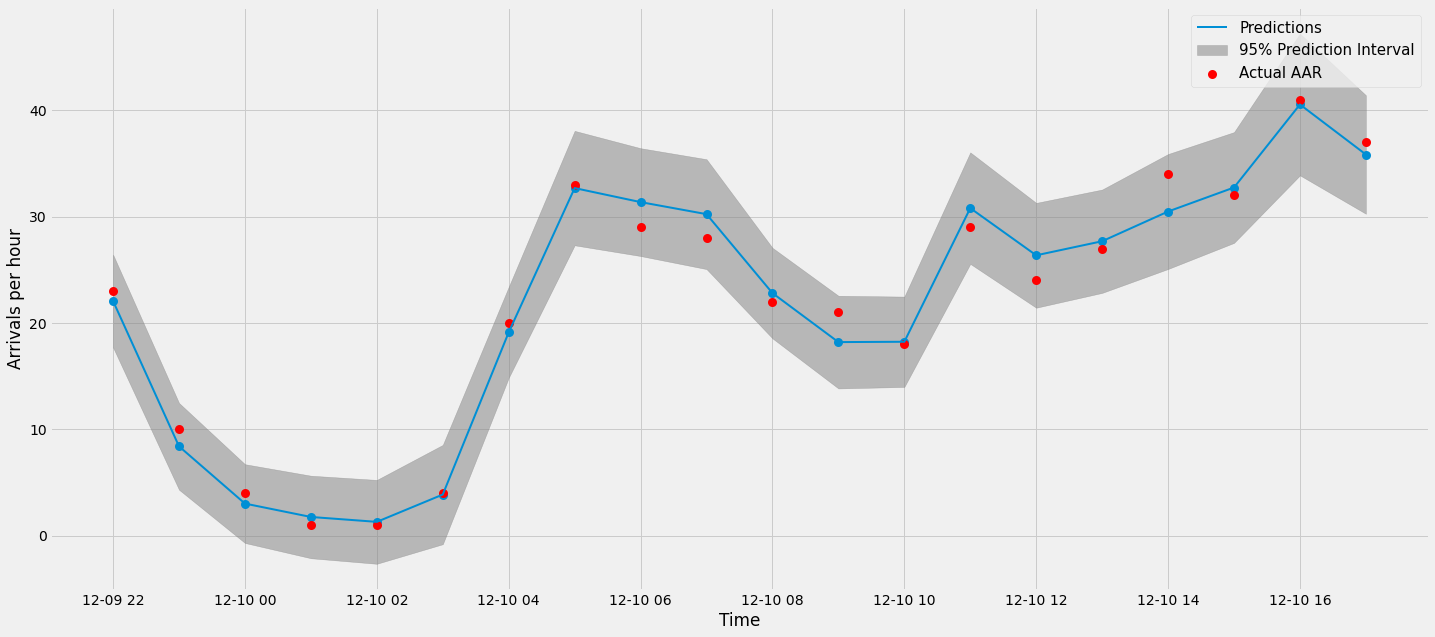

In [16]:
plot_result(prediction, start = 8230, end = 8250)

# NGBoost - example

## NGBoost

In [ ]:
X, Y = load_boston(True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
# prediction
Y_preds = ngb.predict(X_test)

In [ ]:
# estimated distributional parameters at a set of point
Y_dists = ngb.pred_dist(X_test)

Y_dists[0:5].params    

# loc : mean
# scale : standard deviation

In [ ]:
# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, Y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(Y_test).mean()
print('Test NLL', test_NLL)

## Survival Regression

In [ ]:
import numpy as np
from ngboost import NGBSurvival
from ngboost.distns import LogNormal

# Distribution Estimator